## Import python packages

In [1]:
import urllib
import requests
import json
from pprint import pprint
import pandas as pd
import numpy as np
from collections import namedtuple
import re
import matplotlib.pyplot as plt

## Define the ticker we wish to analyze

In [2]:
ticker = 'PLUG'

## Find the CIK number

### Request ticker exchange data from the sec.gov API

In [4]:
# Build up the request URL
domain = 'https://www.sec.gov'
file_path = '/files/company_tickers_exchange.json'
url = domain + file_path

# Run the API request   
request_info = requests.get(url)

# Print the returned status code (200 is good, 404 is bad), and other content info.
print("Request status code:", request_info.status_code)
print("Content Type:", request_info.headers['Content-Type'])
print("Content Length:", request_info.headers['Content-Length'], 'bytes')

Request status code: 200
Content Type: application/json
Content Length: 213729 bytes


In [5]:
# Put the requested content into a Python dict object using the `.json()` method
request_data = request_info.json()

# Verify that the .json() method returned a dict object
print("Data type:", type(request_data))

Data type: <class 'dict'>


### Explore the data that was returned

In [6]:
# We know that request_data is a dictionary, so let's list all of its keys. 
print("request_data:", request_data.keys())

request_data: dict_keys(['fields', 'data'])


In [7]:
request_data['fields']

['cik', 'name', 'ticker', 'exchange']

In [8]:
request_data['data'][0:10]

[[320193, 'Apple Inc.', 'AAPL', 'Nasdaq'],
 [789019, 'MICROSOFT CORP', 'MSFT', 'Nasdaq'],
 [1018724, 'AMAZON COM INC', 'AMZN', 'Nasdaq'],
 [1067983, 'BERKSHIRE HATHAWAY INC', 'BRK-B', 'NYSE'],
 [731766, 'UNITEDHEALTH GROUP INC', 'UNH', 'NYSE'],
 [34088, 'EXXON MOBIL CORP', 'XOM', 'NYSE'],
 [200406, 'JOHNSON & JOHNSON', 'JNJ', 'NYSE'],
 [104169, 'Walmart Inc.', 'WMT', 'NYSE'],
 [19617, 'JPMORGAN CHASE & CO', 'JPM', 'NYSE'],
 [884394, 'SPDR S&P 500 ETF TRUST', 'SPY', 'NYSE']]

### Create a Pandas dataframe from the *request_data* dictionary

In [9]:
# Create a new dataframe
df_tickers = (
    pd.DataFrame(data=request_data['data'], 
                 columns=request_data['fields'])
    .set_index('ticker')
)

# Display the top few rows
df_tickers.head()

,cik,name,exchange
ticker,,,
AAPL,320193,Apple Inc.,Nasdaq
MSFT,789019,MICROSOFT CORP,Nasdaq
AMZN,1018724,AMAZON COM INC,Nasdaq
BRK-B,1067983,BERKSHIRE HATHAWAY INC,NYSE
UNH,731766,UNITEDHEALTH GROUP INC,NYSE


In [26]:
# Slice the dataframe to show only the row where ticker=='AAPL'
df_tickers.query(f"ticker=='{ticker}'")

,cik,name,exchange
ticker,,,
PLUG,1093691,PLUG POWER INC,Nasdaq


### Create a function, so that we can get the values for any ticker

In [11]:
def get_cik_string(ticker_data, ticker_symbol):
    ticker_symbol = ticker_symbol.upper()
    data_slice = ticker_data.loc[[ticker_symbol],['cik']]
    cik_value = data_slice.values[0][0]
    cik_string = 'CIK' + str(cik_value).rjust(10, '0')
    return cik_string

In [29]:
# Example for our ticker
print("ticker:", ticker)
print("CIK:",    get_cik_string(df_tickers, ticker))

ticker: PLUG
CIK: CIK0001093691


## Get financial data from data.sec.gov api

In [13]:
# Build up the request URL
cik = get_cik_string(df_tickers, ticker)
tag = 'Assets'
domain = 'https://data.sec.gov'
file_path = f"/api/xbrl/companyconcept/{cik}/us-gaap/{tag}.json"
url = domain + file_path
print("URL:", url)

# Run the API request   
request_tag_data = requests.get(url, headers={'User-Agent': "mojos-brim-05@icloud.com"})

# Print the returned status code (200 is good, 404 is bad), and other content info.
print("Request status code:", request_tag_data.status_code)
print("Content Type:", request_tag_data.headers['Content-Type'])
print("Content Length:", request_tag_data.headers['Content-Length'], 'bytes')

URL: https://data.sec.gov/api/xbrl/companyconcept/CIK0001093691/us-gaap/Assets.json
Request status code: 200
Content Type: application/json
Content Length: 1826 bytes


In [14]:
tag_data = request_tag_data.json()

In [40]:
pprint(tag_data, depth=2)

{'cik': 1093691,
 'description': 'Sum of the carrying amounts as of the balance sheet date of '
                'all assets that are recognized. Assets are probable future '
                'economic benefits obtained or controlled by an entity as a '
                'result of past transactions or events.',
 'entityName': 'Plug Power Inc',
 'label': 'Assets',
 'tag': 'Assets',
 'taxonomy': 'us-gaap',
 'units': {'USD': [...]}}


In [15]:
df_tag_data = pd.DataFrame.from_dict(tag_data['units']['USD'])

In [16]:
df_tag_data

,end,val,accn,fy,fp,form,filed,frame
0,2010-12-31,59176925,0001003297-11-000292,2011,Q2,10-Q,2011-08-11,NaN
1,2010-12-31,59176925,0001003297-11-000354,2011,Q3,10-Q,2011-11-09,NaN
2,2010-12-31,59176925,0001003297-12-000141,2011,FY,10-K,2012-03-30,CY2010Q4I
3,2011-06-30,59146803,0001003297-11-000292,2011,Q2,10-Q,2011-08-11,CY2011Q2I
4,2011-09-30,53312251,0001003297-11-000354,2011,Q3,10-Q,2011-11-09,CY2011Q3I
...,...,...,...,...,...,...,...,...
101,2021-12-31,5950076000,0001558370-22-002620,2021,FY,10-K,2022-03-01,NaN
102,2021-12-31,5950076000,0001558370-22-007818,2022,Q1,10-Q,2022-05-09,NaN
103,2021-12-31,5950076000,0001558370-22-012895,2022,Q2,10-Q,2022-08-09,CY2021Q4I
104,2022-03-31,5803805000,0001558370-22-007818,2022,Q1,10-Q,2022-05-09,CY2022Q1I


In [17]:
isinstance

<function isinstance(obj, class_or_tuple, /)>

In [18]:
bool(isinstance(re.search(r'^CY', 'CY2011Q2I'), re.Match))

True

In [19]:
starts_with_cy = lambda x: bool(isinstance(re.search(r'^CY', x), re.Match))
year_label = lambda x: 'Current Year' if starts_with_cy(x) else 'Prior Year'

df_plot_data = (
    df_tag_data
    .query("form=='10-Q'")
    .assign(yr_mon = lambda x: [f"{y[0]}-{y[1]}" for y in zip(x.fy, x.fp)] )
    .assign(filter_flag = lambda x: [starts_with_cy(str(y)) for y in x.frame])
    .query("filter_flag==True")
    .filter(['end', 'val'])
    .sort_values(by=['end'])
)

df_plot_data.tail()

,end,val
99,2021-06-30,5788826000
100,2021-09-30,5740100000
103,2021-12-31,5950076000
104,2022-03-31,5803805000
105,2022-06-30,5734404000


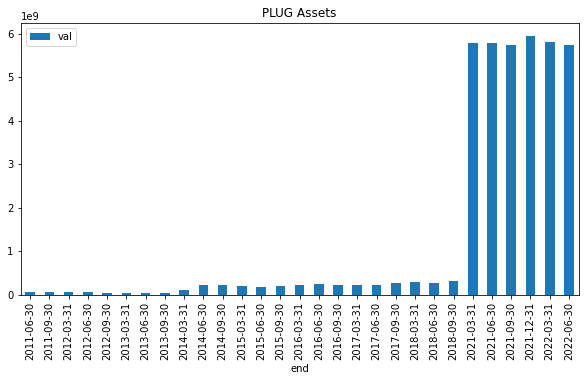

In [25]:
df_plot_data.plot(kind = 'bar', x = 'end', y = 'val', figsize=(10, 5), title = f"{ticker} {tag}")
plt.show()